## Importations

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from src.params import SUBJ_CLEAN, RESULT_PATH, ACTIVE_RUN, PASSIVE_RUN, FIG_PATH, FREQS_LIST, PREPROC_PATH, FREQS_NAMES
from src.utils import get_bids_file
import os
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt

import mne
from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.viz import plot_compare_evokeds
from statsmodels.stats.multitest import fdrcorrection

## Prepare data

In [15]:
task = 'LaughterActive'
subj_list = SUBJ_CLEAN
stage = "epo"

# Select what conditions to compute (str)
cond1 = 'Good'
cond2 = 'BaselineZero'
cond3 = 'Miss'

if cond1 == 'Good' and cond3 == 'Miss' :
    button_cond = True
else :
    button_cond = False
    
conditions = conditions = cond1 + '-' + cond2
condition_list = [cond1, cond2]
picks = "meg" # Select MEG channels

ROI = 'MLT'

In [16]:
# Import data

contrasts_all_subject = []
contrasts_all_subject_all_chan = []

evoked_condition1 = []
evoked_condition2 = []

evoked_condition1_data = []
evoked_condition2_data = []

for subj in SUBJ_CLEAN :
    print("processing -->", subj)

    chan_selected = []

    # Load epochs data
    _, path_epochs = get_bids_file(RESULT_PATH, task=task, subj=subj, stage="AR_epo")
    epochs = mne.read_epochs(path_epochs, verbose=None)
    epochs.apply_baseline(baseline=(None, 0))

    CHAN = epochs.info['ch_names']

    # Select channel of interest
    for chan in CHAN  : 
        if ROI in chan : 
            chan_selected.append(chan)

    epochs_copy = epochs.copy() 
    epochs_copy.pick_channels(chan_selected)

    if button_cond == True : # Compute button press : Combine events Good & Bad
        evoked_cond1_roi = mne.combine_evoked([epochs_copy[cond1].average(), epochs_copy[cond3].average()], weights='nave')
        evoked_cond1_all_chan = mne.combine_evoked([epochs[cond1].average(), epochs[cond3].average()], weights='nave')

    else : # For other conditions
        evoked_cond1_roi = epochs_copy[cond1].average()
        evoked_cond1_all_chan = epochs[cond1].average()

    # Create fake evoked with value=0 
    if cond2 == 'BaselineZero' : 
        baseline_data = np.zeros((epochs_copy.get_data().shape[1], epochs_copy.get_data().shape[2]))
        evoked_cond2_roi = mne.EvokedArray(baseline_data, epochs_copy.info, tmin=-0.5, comment='baseline')

        baseline_data_all_chan = np.zeros((epochs.get_data().shape[1], epochs.get_data().shape[2]))
        evoked_cond2_all_chan = mne.EvokedArray(baseline_data_all_chan, epochs.info, tmin=-0.5, comment='baseline')
    else :
        evoked_cond2_roi = epochs_copy[cond2].average()
        evoked_cond2_all_chan = epochs[cond2].average()


    # Prepare data for ttest with roi
    evoked_condition2_data.append(evoked_cond2_roi.get_data()) 
    evoked_condition1_data.append(evoked_cond1_roi.get_data())

    evoked_condition2.append(evoked_cond2_roi) 
    evoked_condition1.append(evoked_cond1_roi)

# Combine all subject together
evokeds = {cond1 : evoked_condition1, cond2 : evoked_condition2}


processing --> 01
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
296 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-02/sub-02_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
295 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-03/sub-03_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of in

Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 22
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-22/sub-22_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
298 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 23
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-23/sub-23_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
185 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
proce

## Perform paired t-test

In [17]:
# Perform t-test without correction without clusters
cond1_data = np.array(evoked_condition1_data)
cond2_data = np.array(evoked_condition2_data)
print(cond1_data.shape)
print(cond2_data.shape)

# Average signal across channel
cond1_data_ave = np.transpose(np.mean(cond1_data, axis=1), [1, 0])
cond2_data_ave = np.transpose(np.mean(cond2_data, axis=1), [1, 0])

print(cond1_data_ave.shape)
print(cond2_data_ave.shape)

report = "time={i_ti}, t({df})={t_val:.3f}, p={p:.3f}"
print("\nTargeted statistical test results:")

p_vals = []
x_time = []

for i_ti, ti in enumerate(cond1_data_ave):

    data1 = cond1_data_ave[i_ti, :]
    data2 = cond2_data_ave[i_ti, :]

    # conduct t test
    t, p = ttest_rel(data1, data2, axis=None) # Paired t-test

    p_vals.append(p)
    x_time.append(i_ti)

    # display results
    format_dict = dict(
        i_ti=evoked_cond1_roi.times[i_ti], df=len(cond1_data_ave) - 1, t_val=t, p=p
    )
    print(report.format(**format_dict))

(27, 34, 2401)
(27, 34, 2401)
(2401, 27)
(2401, 27)

Targeted statistical test results:
time=-0.5, t(2400)=-3.869, p=0.001
time=-0.49916666666666665, t(2400)=-3.878, p=0.001
time=-0.49833333333333335, t(2400)=-3.812, p=0.001
time=-0.4975, t(2400)=-3.714, p=0.001
time=-0.49666666666666665, t(2400)=-3.627, p=0.001
time=-0.49583333333333335, t(2400)=-3.556, p=0.001
time=-0.495, t(2400)=-3.480, p=0.002
time=-0.49416666666666664, t(2400)=-3.402, p=0.002
time=-0.49333333333333335, t(2400)=-3.338, p=0.003
time=-0.4925, t(2400)=-3.295, p=0.003
time=-0.49166666666666664, t(2400)=-3.262, p=0.003
time=-0.49083333333333334, t(2400)=-3.230, p=0.003
time=-0.49, t(2400)=-3.213, p=0.003
time=-0.4891666666666667, t(2400)=-3.240, p=0.003
time=-0.48833333333333334, t(2400)=-3.311, p=0.003
time=-0.4875, t(2400)=-3.381, p=0.002
time=-0.4866666666666667, t(2400)=-3.400, p=0.002
time=-0.48583333333333334, t(2400)=-3.370, p=0.002
time=-0.485, t(2400)=-3.333, p=0.003
time=-0.4841666666666667, t(2400)=-3.331, p

time=-0.2225, t(2400)=2.567, p=0.016
time=-0.22166666666666668, t(2400)=2.616, p=0.015
time=-0.22083333333333333, t(2400)=2.585, p=0.016
time=-0.22, t(2400)=2.469, p=0.020
time=-0.21916666666666668, t(2400)=2.284, p=0.031
time=-0.21833333333333332, t(2400)=2.085, p=0.047
time=-0.2175, t(2400)=1.940, p=0.063
time=-0.21666666666666667, t(2400)=1.876, p=0.072
time=-0.21583333333333332, t(2400)=1.876, p=0.072
time=-0.215, t(2400)=1.886, p=0.070
time=-0.21416666666666667, t(2400)=1.844, p=0.077
time=-0.21333333333333335, t(2400)=1.710, p=0.099
time=-0.2125, t(2400)=1.484, p=0.150
time=-0.21166666666666667, t(2400)=1.207, p=0.238
time=-0.21083333333333334, t(2400)=0.945, p=0.353
time=-0.21, t(2400)=0.753, p=0.458
time=-0.20916666666666667, t(2400)=0.653, p=0.520
time=-0.20833333333333334, t(2400)=0.629, p=0.535
time=-0.2075, t(2400)=0.644, p=0.525
time=-0.20666666666666667, t(2400)=0.643, p=0.526
time=-0.20583333333333334, t(2400)=0.592, p=0.559
time=-0.205, t(2400)=0.495, p=0.625
time=-0.20

time=0.14666666666666667, t(2400)=-3.996, p=0.000
time=0.1475, t(2400)=-4.002, p=0.000
time=0.14833333333333334, t(2400)=-4.000, p=0.000
time=0.14916666666666667, t(2400)=-3.980, p=0.000
time=0.15, t(2400)=-3.938, p=0.001
time=0.15083333333333335, t(2400)=-3.883, p=0.001
time=0.15166666666666667, t(2400)=-3.828, p=0.001
time=0.1525, t(2400)=-3.788, p=0.001
time=0.15333333333333332, t(2400)=-3.769, p=0.001
time=0.15416666666666667, t(2400)=-3.765, p=0.001
time=0.155, t(2400)=-3.767, p=0.001
time=0.15583333333333332, t(2400)=-3.758, p=0.001
time=0.15666666666666668, t(2400)=-3.725, p=0.001
time=0.1575, t(2400)=-3.666, p=0.001
time=0.15833333333333333, t(2400)=-3.592, p=0.001
time=0.15916666666666668, t(2400)=-3.520, p=0.002
time=0.16, t(2400)=-3.474, p=0.002
time=0.16083333333333333, t(2400)=-3.472, p=0.002
time=0.16166666666666665, t(2400)=-3.523, p=0.002
time=0.1625, t(2400)=-3.627, p=0.001
time=0.16333333333333333, t(2400)=-3.767, p=0.001
time=0.16416666666666666, t(2400)=-3.915, p=0.

time=0.49583333333333335, t(2400)=-2.827, p=0.009
time=0.49666666666666665, t(2400)=-2.821, p=0.009
time=0.4975, t(2400)=-2.803, p=0.009
time=0.49833333333333335, t(2400)=-2.783, p=0.010
time=0.49916666666666665, t(2400)=-2.759, p=0.010
time=0.5, t(2400)=-2.723, p=0.011
time=0.5008333333333334, t(2400)=-2.674, p=0.013
time=0.5016666666666667, t(2400)=-2.624, p=0.014
time=0.5025, t(2400)=-2.582, p=0.016
time=0.5033333333333333, t(2400)=-2.556, p=0.017
time=0.5041666666666667, t(2400)=-2.551, p=0.017
time=0.505, t(2400)=-2.575, p=0.016
time=0.5058333333333334, t(2400)=-2.634, p=0.014
time=0.5066666666666667, t(2400)=-2.725, p=0.011
time=0.5075, t(2400)=-2.840, p=0.009
time=0.5083333333333333, t(2400)=-2.968, p=0.006
time=0.5091666666666667, t(2400)=-3.100, p=0.005
time=0.51, t(2400)=-3.226, p=0.003
time=0.5108333333333334, t(2400)=-3.330, p=0.003
time=0.5116666666666667, t(2400)=-3.393, p=0.002
time=0.5125, t(2400)=-3.399, p=0.002
time=0.5133333333333333, t(2400)=-3.342, p=0.003
time=0.5

time=0.86, t(2400)=-1.557, p=0.132
time=0.8608333333333333, t(2400)=-1.627, p=0.116
time=0.8616666666666667, t(2400)=-1.652, p=0.111
time=0.8625, t(2400)=-1.651, p=0.111
time=0.8633333333333333, t(2400)=-1.657, p=0.110
time=0.8641666666666666, t(2400)=-1.700, p=0.101
time=0.865, t(2400)=-1.797, p=0.084
time=0.8658333333333333, t(2400)=-1.939, p=0.063
time=0.8666666666666667, t(2400)=-2.089, p=0.047
time=0.8675, t(2400)=-2.196, p=0.037
time=0.8683333333333333, t(2400)=-2.228, p=0.035
time=0.8691666666666666, t(2400)=-2.190, p=0.038
time=0.87, t(2400)=-2.110, p=0.045
time=0.8708333333333333, t(2400)=-2.021, p=0.054
time=0.8716666666666667, t(2400)=-1.956, p=0.061
time=0.8725, t(2400)=-1.937, p=0.064
time=0.8733333333333333, t(2400)=-1.970, p=0.060
time=0.8741666666666666, t(2400)=-2.042, p=0.051
time=0.875, t(2400)=-2.124, p=0.043
time=0.8758333333333334, t(2400)=-2.187, p=0.038
time=0.8766666666666667, t(2400)=-2.230, p=0.035
time=0.8775, t(2400)=-2.269, p=0.032
time=0.8783333333333333,

time=1.1608333333333334, t(2400)=-4.154, p=0.000
time=1.1616666666666666, t(2400)=-4.138, p=0.000
time=1.1625, t(2400)=-4.156, p=0.000
time=1.1633333333333333, t(2400)=-4.182, p=0.000
time=1.1641666666666666, t(2400)=-4.197, p=0.000
time=1.165, t(2400)=-4.189, p=0.000
time=1.1658333333333333, t(2400)=-4.152, p=0.000
time=1.1666666666666667, t(2400)=-4.089, p=0.000
time=1.1675, t(2400)=-4.011, p=0.000
time=1.1683333333333332, t(2400)=-3.931, p=0.001
time=1.1691666666666667, t(2400)=-3.864, p=0.001
time=1.17, t(2400)=-3.816, p=0.001
time=1.1708333333333334, t(2400)=-3.785, p=0.001
time=1.1716666666666666, t(2400)=-3.770, p=0.001
time=1.1725, t(2400)=-3.770, p=0.001
time=1.1733333333333333, t(2400)=-3.782, p=0.001
time=1.1741666666666666, t(2400)=-3.806, p=0.001
time=1.175, t(2400)=-3.841, p=0.001
time=1.1758333333333333, t(2400)=-3.880, p=0.001
time=1.1766666666666667, t(2400)=-3.902, p=0.001
time=1.1775, t(2400)=-3.888, p=0.001
time=1.1783333333333332, t(2400)=-3.833, p=0.001
time=1.179

In [56]:
# Select pvalues sig.
pval_corrected = 0.05/len(np.transpose(cond1_data_ave, [1, 0])) #Number of time point

correction = 'FDR'

time_corr = []
pval_corr = []

if correction == 'Bonferroni' :
    print('Apply Bonferroni correction') # Boneferroni correction
    for i, pval in enumerate(p_vals) : 
        if pval < pval_corrected :
            pval_corr.append(pval)
            time_corr.append(evoked_cond1_roi.times[i])

elif correction == 'FDR' :
    print('Apply FDR correction') # FDR correction

    _, qval = fdrcorrection(p_vals, 
                    alpha=0.05)

    for i, q in enumerate(qval) : 
        if q < 0.05 : 
            time_corr.append(evoked_cond1_roi.times[i])
            pval_corr.append(q)

else : # No correction applied
    print("No correction applied")

        pval_corr.append(pval)
        time_corr.append(evoked_cond1_roi.times[i])

Apply FDR correction


In [57]:
len(time_corr)

1701

In [58]:
len(pval_corr)

1701

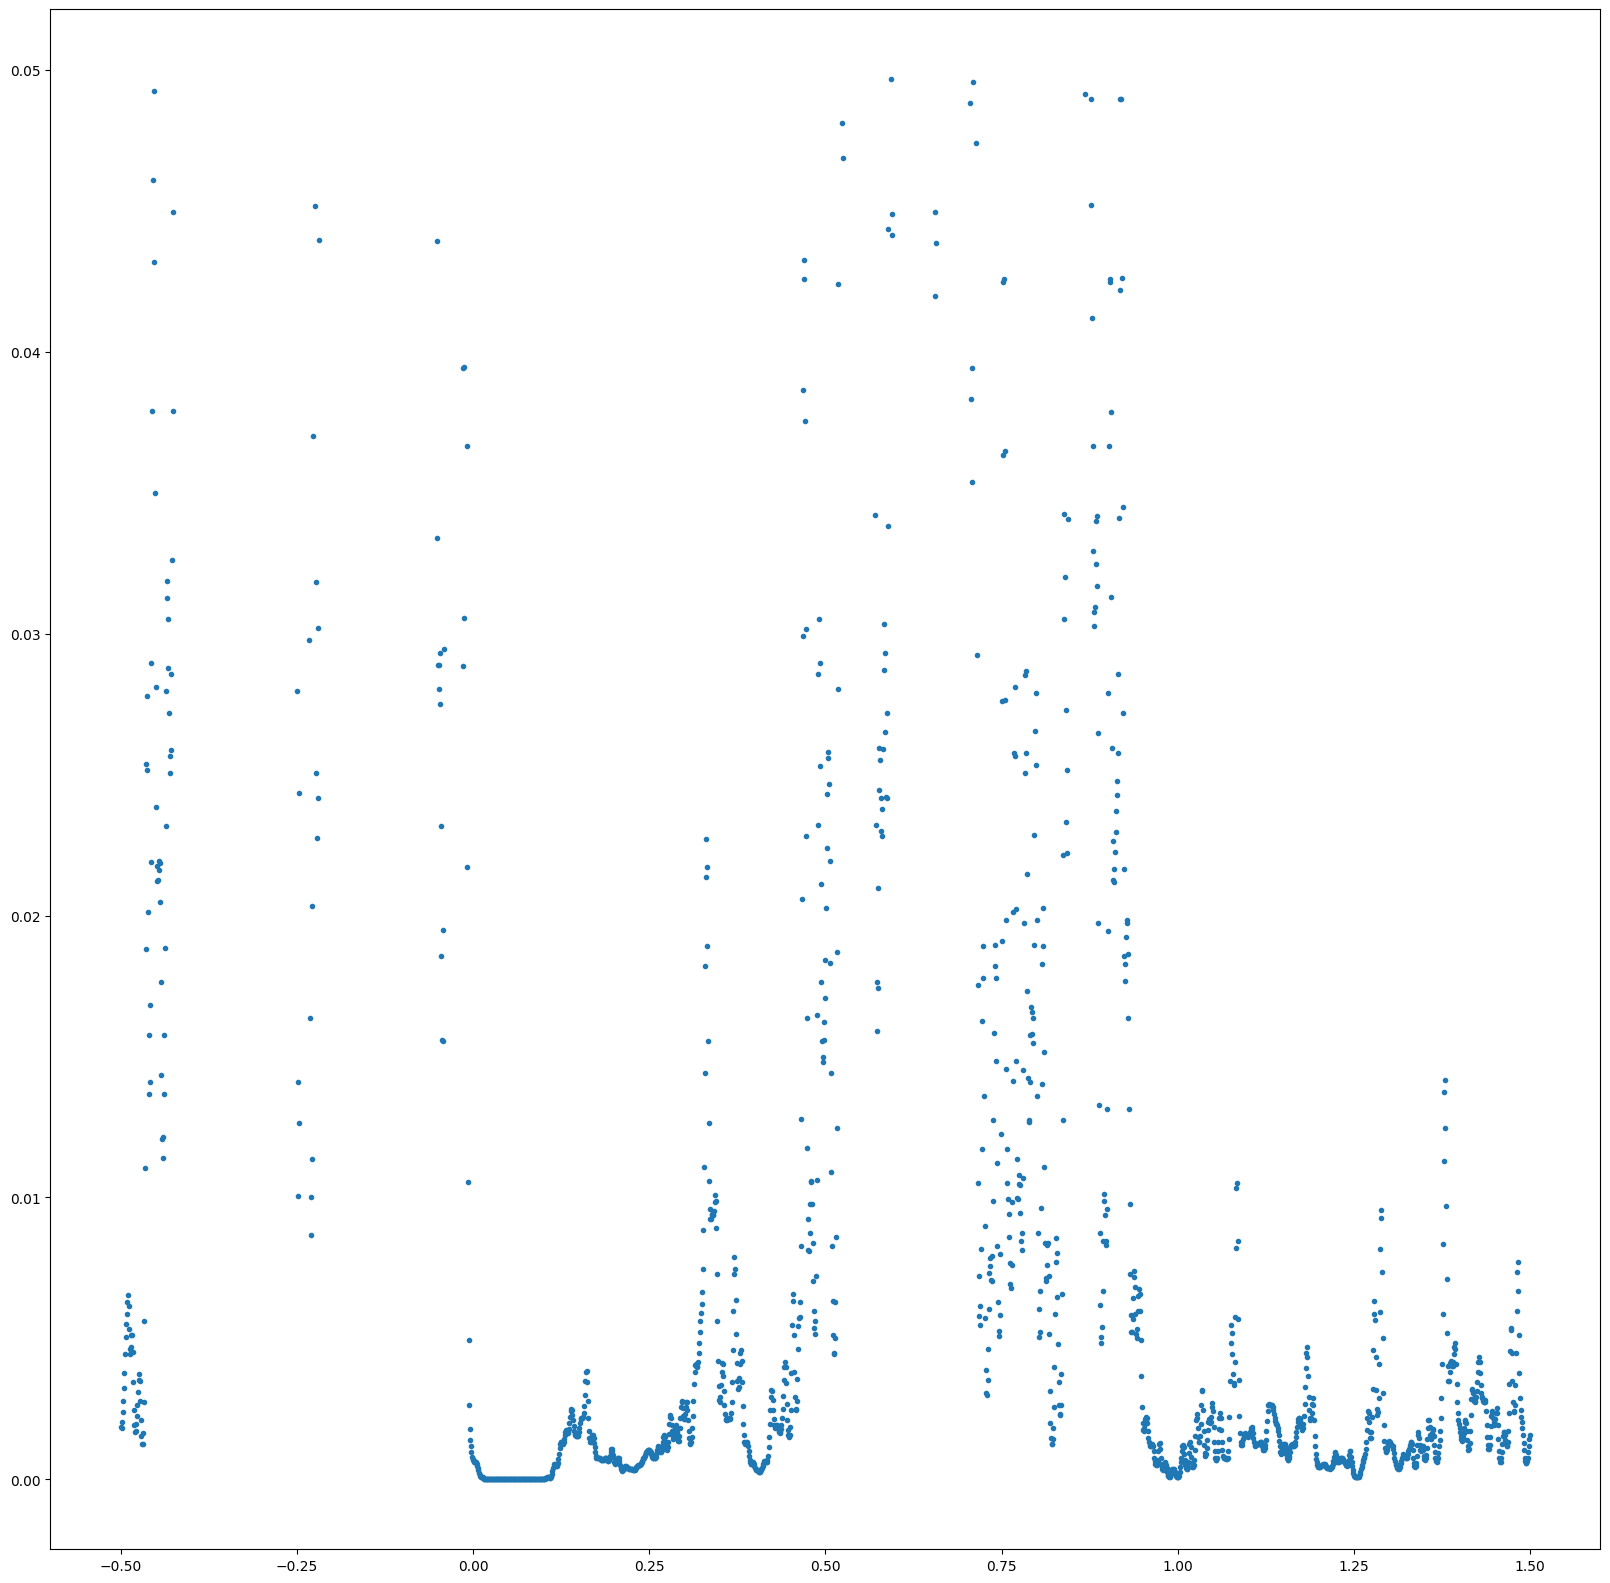

In [59]:
# Plot pvals sig through time : use this just for visual representation
y = np.array(pval_corr)
x_plot = np.array(time_corr)

fig, ax = plt.subplots(1, figsize=(20, 20))
plt.plot(x_plot, y, marker='.', linestyle='None')

plt.show()

## Plot

combining channels using "mean"
combining channels using "mean"
Save figure


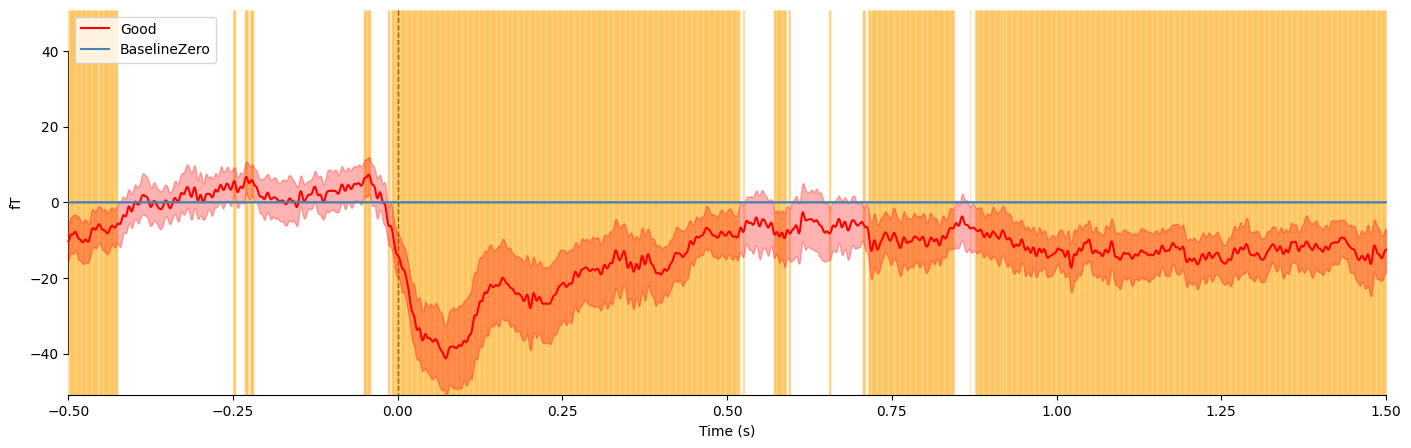

In [62]:
colors = "r",'steelblue'

fig, ax = plt.subplots(1, 1, figsize=(17, 5))

plot_compare_evokeds(evokeds,
                colors=colors, show=False, axes=ax,
                split_legend=True, truncate_yaxis='auto', combine="mean")

if len(pval_corr) != 0 :
    for i, val in enumerate(pval_corr):
        sig_times = []

        # plot temporal cluster extent
        sig_times.append(time_corr[i])
        ymin, ymax = ax.get_ylim()
        ax.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                            color='orange', alpha=0.3)
    print('Save figure')
    plt.show()
else : 
    print('Save figure')
    plt.show()
